In [1]:
import sys
import os
from dotenv import load_dotenv

import numpy as np
import pandas as pd
import sqlalchemy as sq
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

import tensorflow
from tensorflow import keras
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense



sys.path.append("../Shared/")
from DataService import DataService

/tmp/ipykernel_3461617/673676398.py:10: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport
2023-07-19 16:06:54.574070: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 16:06:55.080858: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
sys.path.append("../Datasets/")
from DataCreation import getDatasetV1, getDatasetV2

In [3]:
# disable GPU
tensorflow.config.set_visible_devices([], 'GPU')  # Hide GPU devices
tensorflow.config.set_visible_devices(tensorflow.config.list_physical_devices('CPU'), 'CPU')  # Show CPU devices

2023-07-19 16:06:55.581845: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-19 16:06:55.610627: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-19 16:06:55.610915: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### fetch data

In [4]:
df = getDatasetV1(None)
df.drop_duplicates(inplace=True)
df['has_ergot'] = df['has_ergot'].astype(int) # 0: Flase, 1: True
df

,year,district,mean_temp,mean_snow_on_grnd,mean_total_precip,mean_total_rain,mean_total_snow,has_ergot
0,1995,4860,0.451735,6.005903,1.189348,0.529384,0.303979,0
1,1995,4810,4.239744,0.860822,0.871078,0.328105,0.116534,0
2,1995,4840,1.628772,3.564932,0.790694,0.250507,0.155237,1
3,1995,4830,3.060292,1.054999,1.299196,0.332711,0.135583,1
4,1995,4731,2.796575,0.010959,0.908037,0.078265,0.010502,1
...,...,...,...,...,...,...,...,...
1059,2022,4605,0.777808,14.356164,1.151507,0.000000,0.000000,1
1060,2022,4720,2.653288,6.519178,1.097808,0.000000,0.000000,1
1061,2022,4611,1.931507,5.945205,2.099726,0.000000,0.000000,1
1062,2022,4751,1.386849,5.210959,1.102466,0.000000,0.000000,1


### spliting data

In [5]:
# split data into train, validate and test
TARGET = 'has_ergot'
PIVOT = 2019

# split datframe till 2018
df_train = df[df['year'] < PIVOT]
df_train.drop(columns=['year', 'district'], inplace=True)
X_train_df = df_train.drop(columns=[TARGET])
y_train_df = df_train[TARGET]

# split data into test and validate
X_train, X_val, y_train, y_val = train_test_split(X_train_df, y_train_df, test_size=0.2, random_state=42, stratify=y_train_df)

#split dataframe from 2019
df_test = df[df['year'] >= PIVOT]
df_test.drop(columns=['year', 'district'], inplace=True)
X_test = df_test.drop(columns=[TARGET])
y_test = df_test[TARGET]


/tmp/ipykernel_3461617/648410302.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(columns=['year', 'district'], inplace=True)
/tmp/ipykernel_3461617/648410302.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(columns=['year', 'district'], inplace=True)


### normalizing and over sampling

In [6]:
# normalizing data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# oversampling data
ros = RandomOverSampler(random_state=42)
X_train_rs, y_train_rs = ros.fit_resample(X_train, y_train)


In [7]:
# create a list for training set, validation set and test set
train_list = [X_train_rs, y_train_rs]
val_list = [X_val, y_val]
test_list = [X_test, y_test]

In [8]:
# checking for biasness
print(f"Train:\n{y_train.value_counts()}")
print(f"Train Resample:\n{y_train_rs.value_counts()}")
print(f"Validation:\n{y_val.value_counts()}")

Train:
1    599
0    130
Name: has_ergot, dtype: int64
Train Resample:
1    599
0    599
Name: has_ergot, dtype: int64
Validation:
1    150
0     33
Name: has_ergot, dtype: int64


### model creation

In [9]:
def create_model(feature_num = 0,
                 layer_node = [32, 16, 32, 16, 8, 1],
                 activation_fn='relu', 
                 optimizer_fn='adam', 
                 loss_fn='binary_crossentropy'
                 ):
    
    model = Sequential()

    layers_node = layer_node

    for i in range(len(layers_node)):
        if i == 0:
            model.add(Dense(layers_node[i], activation=activation_fn, kernel_regularizer=l1_l2(0.01) ,input_dim=X_train.shape[1])) #, kernel_regularizer=l2(0.01)
        elif(i == len(layers_node) - 1): # last/output layer
            model.add(Dense(layers_node[i], activation='sigmoid')) # , kernel_regularizer=l2(0.01)
        # elif(i%2 == 0):
        #     model.add(Dropout(0.2))
        else:
            model.add(Dense(layers_node[i], activation=activation_fn, kernel_regularizer=l1_l2(0.01)))
            

    model.compile(optimizer=optimizer_fn, loss=loss_fn, metrics=['accuracy'])

    return model

In [10]:
#------------------ Model Parameters ------------------#
feature_num = X_train.shape[1]
layer_node = [32, 16, 32, 16, 8, 1]
activation_fn='relu'
optimizer_fn='adam'
loss_fn='binary_crossentropy'
#------------------------------------------------------#

model = create_model(feature_num, layer_node=layer_node, activation_fn=activation_fn, optimizer_fn=optimizer_fn, loss_fn=loss_fn)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                192       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 32)                544       
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,937
Trainable params: 1,937
Non-trainabl

### training

In [12]:
# h = model.fit(X_train_rs, y_train_rs, epochs=500, batch_size=32, validation_data=(X_val, y_val))

In [17]:
def train(model=model, train_list=train_list, val_list=val_list, epochs=500, batch_size=32):

    X_train, y_train = train_list
    X_val, y_val = val_list

    # # Train model (use 20% of training set as validation set)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

    # # Train model (use validation data as validation set)
    # history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

    return history

In [18]:
history = train(model=model, train_list=train_list, val_list=val_list, epochs=500, batch_size=32)

Epoch 1/500
38/38 [==============================] - 0s 2ms/step - loss: 0.6954 - accuracy: 0.5000 - val_loss: 0.6949 - val_accuracy: 0.8197
Epoch 2/500
38/38 [==============================] - 0s 1ms/step - loss: 0.6954 - accuracy: 0.5000 - val_loss: 0.6946 - val_accuracy: 0.8197
Epoch 3/500
38/38 [==============================] - 0s 1ms/step - loss: 0.6954 - accuracy: 0.5000 - val_loss: 0.6947 - val_accuracy: 0.8197
Epoch 4/500
38/38 [==============================] - 0s 1ms/step - loss: 0.6955 - accuracy: 0.4816 - val_loss: 0.6951 - val_accuracy: 0.8197
Epoch 5/500
38/38 [==============================] - 0s 1ms/step - loss: 0.6954 - accuracy: 0.5000 - val_loss: 0.6948 - val_accuracy: 0.8197
Epoch 6/500
38/38 [==============================] - 0s 1ms/step - loss: 0.6955 - accuracy: 0.4833 - val_loss: 0.6956 - val_accuracy: 0.1803
Epoch 7/500
38/38 [==============================] - 0s 1ms/step - loss: 0.6954 - accuracy: 0.4816 - val_loss: 0.6951 - val_accuracy: 0.8197
Epoch 8/500
3

### evaluate model

In [15]:
def evaluate_model(history):
    # Get the training and validation loss from the history
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    # Get the training and validation accuracy from the history
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']

    # Plot the training and validation loss
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot the training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(training_accuracy, label='Training Accuracy')
    plt.plot(validation_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

    # Check if the model is overfitting, underfitting, or performing well
    final_training_loss = np.array(training_loss).mean()
    final_validation_loss = np.array(validation_loss).mean()

    final_training_accuracy = np.array(training_accuracy).mean()
    final_validation_accuracy = np.array(validation_accuracy).mean()

    if final_training_loss < final_validation_loss:
        print("The model is likely underfitting.")
    elif final_training_loss > final_validation_loss:
        print("The model is likely overfitting.")
    else:
        print("The model is performing well and generalizing to new data.")

    if final_training_accuracy == 1.0 and final_validation_accuracy == 1.0:
        print("The model has achieved 100% accuracy on both training and validation data.")

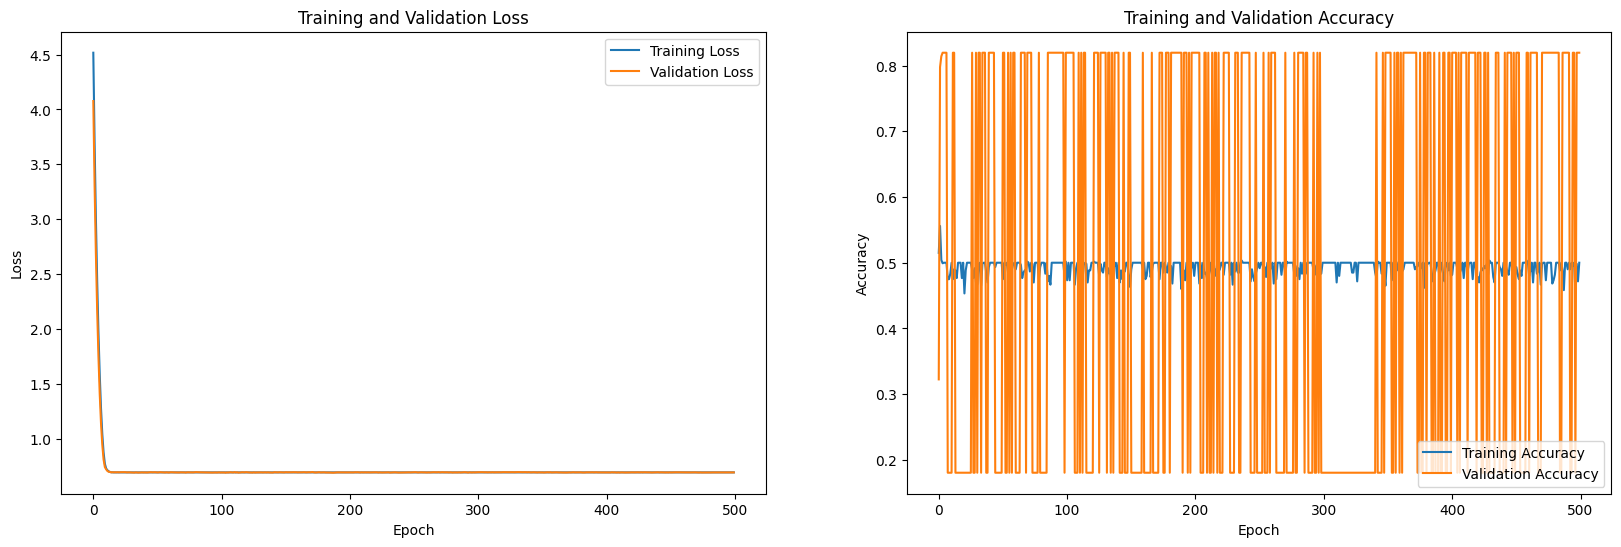

The model is likely overfitting.


In [16]:
evaluate_model(history)